## Convolutional NN to classify govuk content to level2 taxons

Based on:
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

### Load requirements and data

In [9]:
!pip3 freeze requirements


appnope==0.1.0
awscli==1.11.190
backports-abc==0.5
bleach==1.5.0
botocore==1.7.48
colorama==0.3.7
cycler==0.10.0
decorator==4.1.2
docutils==0.14
entrypoints==0.2.3
enum34==1.1.6
html5lib==0.9999999
ipykernel==4.6.1
ipython==6.2.1
ipython-genutils==0.2.0
ipywidgets==7.0.5
jedi==0.11.0
Jinja2==2.10
jmespath==0.9.3
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.1.0
jupyter-console==5.2.0
jupyter-core==4.4.0
Keras==2.1.2
lxml==4.1.1
Markdown==2.6.9
MarkupSafe==1.0
matplotlib==2.1.0
mistune==0.8.1
nbconvert==5.3.1
nbformat==4.4.0
notebook==5.2.1
numpy==1.13.3
pandas==0.21.0
pandocfilters==1.4.2
parso==0.1.0
pexpect==4.3.0
pickleshare==0.7.4
prompt-toolkit==1.0.15
protobuf==3.5.0.post1
ptyprocess==0.5.2
pyasn1==0.3.7
Pygments==2.2.0
pyparsing==2.2.0
python-dateutil==2.6.1
pytz==2017.3
PyYAML==3.12
pyzmq==16.0.3
qtconsole==4.3.1
rsa==3.4.2
s3transfer==0.1.11
scipy==1.0.0
seaborn==0.8.1
simplegeneric==0.8.1
six==1.11.0
tensorflow==1.4.0
tensorflow-tensorboard==0.4.0rc3
terminado==0.7
testp

In [8]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import (Embedding, Input, Dense, 
                          Activation, Conv1D, MaxPooling1D, Flatten)
from keras.models import Model, Sequential
from keras.optimizers import rmsprop
from keras.callbacks import TensorBoard
from sklearn.preprocessing import LabelEncoder

ImportError: cannot import name 'np_utils'

In [2]:
!which python3

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/bin/python3


In [3]:
%time content = pd.read_csv('../../data/clean_content.csv.gz', compression='gzip')

CPU times: user 56.6 s, sys: 10.1 s, total: 1min 6s
Wall time: 1min 11s


In [4]:
%time taxons = pd.read_csv('../../data/clean_taxons.csv')

CPU times: user 26.2 ms, sys: 8.6 ms, total: 34.8 ms
Wall time: 37.8 ms


##  ------------- This data prep step should move to clean_content.py -------------

Remove taxons that are legacy (Imported), World, Corporate information.

In [5]:
taxons = taxons[['base_path','content_id','taxon_name','level1taxon','level2taxon','level3taxon','level4taxon']]

taxons['level1taxon'] = taxons['level1taxon'].astype('str')

# Drop taxons that start with Imported (i.e. legacy taxons at the top level)

taxons = taxons[~taxons['level1taxon'].str.startswith("Imported")]
taxons = taxons[~taxons['taxon_name'].str.startswith("Imported")]

print("Taxons shape after deleting imported top taxons: {}".format(taxons.shape))

taxons = taxons[taxons.level1taxon != 'World']
taxons = taxons[taxons.taxon_name != 'World']

print("Taxons shape after deleting 'World' top taxons: {}".format(taxons.shape))

taxons = taxons[taxons.level1taxon != 'Corporate information']
taxons = taxons[taxons.taxon_name != 'Corporate information']
print("Taxons shape after deleting 'corporate information' top taxons: {}".format(taxons.shape))

# Convert nans to None

taxons['level1taxon'] = taxons['level1taxon'].where(taxons['level1taxon'] != 'nan', None)
taxons['level2taxon'] = taxons['level2taxon'].where(~taxons['level2taxon'].isnull(), None)

print("Taxons shape after converting nans to Nones: {}".format(taxons.shape))

Taxons shape after deleting imported top taxons: (4530, 7)
Taxons shape after deleting 'World' top taxons: (2028, 7)
Taxons shape after deleting 'corporate information' top taxons: (2027, 7)
Taxons shape after converting nans to Nones: (2027, 7)


In [6]:
taxons.head()

,base_path,content_id,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon
0,/business/taxon,495afdb6-47be-4df1-8b38-91c8adb1eefc,Business,None,None,NaN,NaN
2,/crime-justice-and-law,ba951b09-5146-43be-87af-44075eac3ae9,"Crime, justice and law",None,None,NaN,NaN
3,/defence,e491505c-77ae-45b2-84be-8c94b94f6a2b,Defence,None,None,NaN,NaN
4,/childcare-parenting/entering-staying-uk,ba3a9702-da22-487f-86c1-8334a730e559,Entering and staying in the UK,None,None,NaN,NaN
5,/environment,3cf97f69-84de-41ae-bc7b-7e2cc238fa58,Environment,None,None,NaN,NaN


In [7]:
content.head()

,Unnamed: 0,base_path,content_id,description,details,document_type,first_published_at,locale,primary_publishing_organisation,publishing_app,title,body,combined_text,variable,taxon_id
0,0,/vehicle-tax,fa748fae-3de4-4266-ae85-0797ada3f40c,renew or tax your vehicle for the first time u...,"{'will_continue_on': '', 'department_analytics...",transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,tax your vehicle,,tax your vehicle renew or tax your vehicle for...,0,948b6dd4-45b3-45ab-a5c6-5dbce75542a6
1,1,/student-finance-register-login,e57daef4-5eb5-431c-b0ad-14119ab0355f,your student finance online account - check pa...,{'will_continue_on': 'the Student Finance Engl...,transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,student finance login,,student finance login your student finance onl...,0,64aa6eec-48b5-481d-9131-9c8b6326eea1
2,3,/get-information-about-a-company,9ca1a27b-af7b-44d2-b10d-0a6d0e3ff53d,get company information including registered a...,"{'will_continue_on': '', 'department_analytics...",transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,get information about a company,,get information about a company get company in...,0,a1119685-ffef-4417-a3e4-116014ad4523
3,4,/check-vehicle-tax,0889f128-e479-465f-b3e1-a3db6a3879cf,check and report if a vehicle has up-to-date v...,"{'will_continue_on': '', 'department_analytics...",transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,check if a vehicle is taxed,,check if a vehicle is taxed check and report i...,0,948b6dd4-45b3-45ab-a5c6-5dbce75542a6
4,5,/jobsearch,a01fcb59-5dc8-4bf5-b06d-dd567a6d2f5f,find a job using the universal jobmatch servic...,"{'will_continue_on': 'Universal Jobmatch', 'de...",transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,find a job with universal jobmatch,,find a job with universal jobmatch find a job ...,0,21bfd8f6-3360-43f9-be42-b00002982d70


Combine the taxons with the content 

In [8]:
%time content_taxons = pd.merge(left=content, right=taxons, left_on='taxon_id', right_on='content_id', how='outer', indicator=True)

assert content_taxons.shape == (335720, 23)
content_taxons.shape

CPU times: user 1.41 s, sys: 208 ms, total: 1.62 s
Wall time: 1.73 s


(335720, 23)

##  --------------------------------------------------

In [9]:
print('There are {} missing level2taxons (which we need to predict) out of a total {} content items.'
      .format(sum(content_taxons['level2taxon'].isnull()), 
              len(content_taxons['level2taxon'].isnull())))

There are 266753 missing level2taxons (which we need to predict) out of a total 335720 content items.


Drop rows where there are no level2 taxons (i.e. we need to predict for them)

In [10]:
content_taxons.dropna(subset = ['level2taxon'], inplace=True)
print('This leaves us with {} pre-classified rows.'.format(content_taxons.shape[0]))

This leaves us with 68967 pre-classified rows.


There are likely to be lots of content items that have more than one tag. Check here and remove for now:

__TODO: devise a way to deal with multiple tags applied to each content item.__

In [11]:
# Identify where duplicates exist on content_id and count

dupes = content_taxons['content_id_x'].value_counts().to_frame('dupes')
dupes = dupes.groupby('dupes').size().to_frame('count')

# Add index as a column

dupes.reset_index(level=0, inplace=True)
dupes


,dupes,count
0,1,43212
1,2,8871
2,3,1614
3,4,447
4,5,79
5,6,43
6,7,8
7,8,10
8,9,2
9,10,5


In [12]:
multiple_tags = sum(dupes.loc[dupes['dupes'] > 1, 'count'])
single_tags = sum(dupes.loc[dupes['dupes'] == 1, 'count'])

print('Stripping multiply applied tags to one will '
      'leave a total of {} tagged content items to train on'
      .format(multiple_tags + single_tags))

Stripping multiply applied tags to one will leave a total of 54330 tagged content items to train on


In [13]:
print('Before deduplication that are {} items.'.format(content_taxons.shape))
      
content_taxons.drop_duplicates(subset = ['content_id_x'], inplace=True)
      
print('After deduplication that are {} items.'.format(content_taxons.shape))


Before deduplication that are (68967, 23) items.
After deduplication that are (54331, 23) items.


format our text samples and labels into tensors that can be fed into a neural network. To do this, we will rely on Keras utilities keras.preprocessing.text.Tokenizer and keras.preprocessing.sequence.pad_sequences.

`AttributeError: 'float' object has no attribute 'lower'` error suggests that there are `NaN`s in `content_taxons['combined_text']`.

In [21]:
#missing = content_taxons['combined_text'].isnull()

#content_taxons[missing]

# Drop this weird row!
# TODO: remove hardcoding

#content_taxons['combined_text'].drop(335627, inplace=True)

#content_taxons[content_taxons['combined_text'].isnull()]

In [22]:

texts = list(content_taxons['combined_text'])


## Hyperparameters

In [23]:
#MAX_NB_WORDS
MAX_SEQUENCE_LENGTH = 1000
#EMBEDDING_DIM

Note: when using the categorical_crossentropy loss, your targets should be in categorical format (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros expect for a 1 at the index corresponding to the class of the sample). In order to convert integer targets into categorical targets, you can use the Keras utility to_categorical

In [24]:
%time tokenizer = Tokenizer(num_words=20000)

CPU times: user 28 µs, sys: 10 µs, total: 38 µs
Wall time: 41 µs


In [25]:
%time tokenizer.fit_on_texts(texts)

CPU times: user 51.8 s, sys: 1.89 s, total: 53.7 s
Wall time: 55.5 s


In [26]:
%time sequences = tokenizer.texts_to_sequences(texts) #yield one sequence per input textb

CPU times: user 26.7 s, sys: 486 ms, total: 27.2 s
Wall time: 27.5 s


DescribeResult(nobs=54330, minmax=(2, 31140), mean=371.40793300202466, variance=413474.73261022422, skewness=8.94342786914698, kurtosis=215.25851556203574)
ModeResult(mode=array([45]), count=array([371]))
157.0


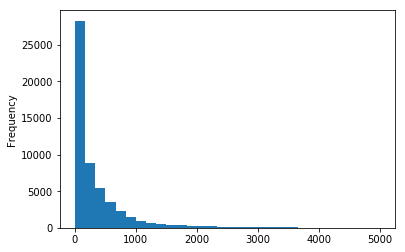

In [66]:
import matplotlib.pyplot as plt
from scipy import stats
% matplotlib inline
page_length = np.array([len(i) for i in sequences])
print(stats.describe(page_length))
print(stats.mode(page_length))
print(np.median(page_length))

pd.Series(page_length[page_length < 5000]).plot(kind='hist', bins = 30)

(array([  395.,  2943.,  4929.,  4822.,  4306.,  2973.,  2405.,  1959.,
         1576.,  1801.,  1370.,  1087.,  1109.,   951.,   915.,   775.,
          749.,   657.,   671.,   694.,   641.,   621.,   590.,   509.,
          568.,   549.,   544.,   487.,   468.,   483.]),
 array([   0.        ,   16.66666667,   33.33333333,   50.        ,
          66.66666667,   83.33333333,  100.        ,  116.66666667,
         133.33333333,  150.        ,  166.66666667,  183.33333333,
         200.        ,  216.66666667,  233.33333333,  250.        ,
         266.66666667,  283.33333333,  300.        ,  316.66666667,
         333.33333333,  350.        ,  366.66666667,  383.33333333,
         400.        ,  416.66666667,  433.33333333,  450.        ,
         466.66666667,  483.33333333,  500.        ]),
 <a list of 30 Patch objects>)

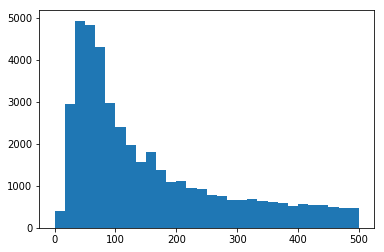

In [69]:
plt.hist(page_length, 30, range = (0, 500))

In [70]:
%time word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs
Found 146347 unique tokens.


In [71]:
%time data = pad_sequences(sequences, maxlen= MAX_SEQUENCE_LENGTH) #MAX_SEQUENCE_LENGTH

CPU times: user 1.67 s, sys: 245 ms, total: 1.91 s
Wall time: 1.92 s


In [72]:
# encode class values as integers

labels = list(content_taxons['level2taxon']) 
#possible that this is just a unique list rather than Y array
#labels_index = dict(zip(allcontent['toptaxon_cat'], allcontent['toptaxon_code']))

encoder = LabelEncoder()
encoder.fit(labels)
labels_encoded = encoder.transform(labels)

# convert integers to dummy variables (i.e. one hot encoded)
labels_onehot = to_categorical(labels_encoded)

In [73]:
print('Shape of data tensor:', len(data))
print('Shape of label tensor:', labels_onehot.shape)

labels_onehot.shape
labels_onehot

Shape of data tensor: 54330
Shape of label tensor: (54331, 103)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [77]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels_encoded[indices]
nb_validation_samples = int(0.2 * data.shape[0]) #validation split
print('nb_validationsamples:', nb_validation_samples)

x_train = data[:-nb_validation_samples]
print('Shape of x_train:', x_train.shape)
y_train = labels[:-nb_validation_samples]
print('Shape of y_train:', y_train.shape)
x_val = data[-nb_validation_samples:]
print('Shape of x_val:', x_val.shape)
y_val = labels[-nb_validation_samples:]
print('Shape of y_val:', y_val.shape)

nb_validationsamples: 10866
Shape of x_train: (43464, 1000)
Shape of y_train: (43464,)
Shape of x_val: (10866, 1000)
Shape of y_val: (10866,)


### preparing the Embedding layer
compute an index mapping words ot known embeddings by parsing the data dump of pre-trained embeddings
NB stopwords haven't been removed yet...

In [79]:
embeddings_index = {}
f = open(os.path.join('../../data/glove.6B', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

CPU times: user 350 µs, sys: 461 µs, total: 811 µs
Wall time: 549 µs
Found 400000 word vectors.


compute embedding matrix using embedding_index dict and word_index

In [80]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))# used 6B.100d.txt
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

load this embedding matrix into an Embedding layer. Note that we set trainable=False to prevent the weights from being updated during training.

In [81]:
embedding_layer = Embedding(len(word_index) + 1,
                            100, # used 6B.100d.txt
                            weights=[embedding_matrix],
                            input_length= MAX_SEQUENCE_LENGTH, #MAX_SEQUENCE LENGTH
                            trainable=False)

An Embedding layer should be fed sequences of integers, i.e. a 2D input of shape (samples, indices). These input sequences should be padded so that they all have the same length in a batch of input data (although an Embedding layer is capable of processing sequence of heterogenous length, if you don't pass an explicit input_length argument to the layer).

All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the embedding matrix, i.e. the sequence [1, 2] would be converted to [embeddings[1], embeddings[2]]. This means that the output of the Embedding layer will be a 3D tensor of shape (samples, sequence_length, embedding_dim).

## Training a 1D convnet

In [82]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32') #MAX_SEQUENCE_LENGTH
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(x_train), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Metric values are recorded at the end of each epoch on the training dataset. If a validation dataset is also provided, then the metric recorded is also calculated for the validation dataset.

All metrics are reported in verbose output and in the history object returned from calling the fit() function. In both cases, the name of the metric function is used as the key for the metric values. In the case of metrics for the validation dataset, the “val_” prefix is added to the key.

In [88]:
logname = 'tf_logs/allgovuk_' + str(datetime.now())

tb = TensorBoard(
    log_dir=logname, histogram_freq=1, write_graph=True, write_images=True)

#tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=1, write_graph=True, write_images=True)

In [89]:
model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=4, batch_size=128, 
    callbacks=[tb]
)

Train on 43464 samples, validate on 10866 samples
Epoch 1/4
43464/43464 [==============================] - 447s 10ms/step - loss: 3.8459 - acc: 0.0895 - val_loss: 3.8067 - val_acc: 0.0918
Epoch 2/4
43464/43464 [==============================] - 468s 11ms/step - loss: 3.8127 - acc: 0.0895 - val_loss: 3.8067 - val_acc: 0.0918
Epoch 3/4
43464/43464 [==============================] - 476s 11ms/step - loss: 3.7956 - acc: 0.0895 - val_loss: 3.8068 - val_acc: 0.0918
Epoch 4/4
43464/43464 [==============================] - 454s 10ms/step - loss: 3.7708 - acc: 0.0895 - val_loss: 3.8300 - val_acc: 0.0918


Improve accuracy by training longer with some regularization mechanism (such as dropout) or by fine-tuning the Embedding layer.

We can also test how well we would have performed by not using pre-trained word embeddings, but instead initializing our Embedding layer from scratch and learning its weights during training. We just need to replace our Embedding layer with the following:

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH)
                            
After 2 epochs, this approach only gets us to 90% validation accuracy, less than what the previous model could reach in just one epoch. Our pre-trained embeddings were definitely buying us something. In general, using pre-trained embeddings is relevant for natural processing tasks were little training data is available (functionally the embeddings act as an injection of outside information which might prove useful for your model).

